<a href="https://colab.research.google.com/github/neuromatch/climate-course-content/blob/main/projects/project-notebooks/Heatwaves_2024.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>   <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/climate-course-content/main/projects/project-notebooks/Heatwaves_2024.ipynb" target="_blank"><img alt="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"/></a>

# Heatwaves

**Content creators:** Wil Laura

**Content reviewers:** Will Gregory, Paul Heubel, Laura Paccini, Jenna Pearson, Ohad Zivan

**Content editors:** Paul Heubel

**Production editors:** Paul Heubel, Konstantine Tsafatinos

**Our 2024 Sponsors:** CMIP, NFDI4Earth

##  Project Background


In [ ]:
# @title Project Background

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'aXBq-A8JsPE'), ('Bilibili', 'BV1KpGDe5E23'), ('Osf', '<video_id_3>')]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @markdown
from IPython.display import IFrame
from ipywidgets import widgets
out = widgets.Output()
with out:
    print(f"If you want to download the slides: https://osf.io/download/zeyxn/")
    display(IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/zeyxn/?direct%26mode=render%26action=download%26mode=render", width=730, height=410))
display(out)

If you want to download the slides: https://osf.io/download/zeyxn/


**In this project**, you will look into the characterization of heatwaves using near-surface air temperature reanalysis data. Since we are talking about extreme events when the temperature exceeds a certain threshold for a continuous number of days, we will first analyze the global spatial and temporal distribution of air temperature. Next, we will calculate the number and timing of heatwaves for a local area, then focus on determining the percentage of a region under heat waves. Additionally, you will be able to explore its relationship with other climate drivers. Also, you are encouraged to analyze the health impact of heatwaves using an available mortality dataset. Finally, enjoy exploring the heatwaves!


# Project Template

  <img src='../template-images/2024_Heatwaves.svg'>

# Data Exploration Notebook

## Project Setup

In [ ]:
# this cell enables anaconda in google colab and has to be run At First
# it will force the kernel to restart, this is necessary to install all system dependencies of cfgrib
# which in turn allows us to open grib files via xarray
#!pip install -q condacolab
#import condacolab
#condacolab.install()

In [ ]:
# google colab installs

#!mamba install --quiet cartopy cdsapi cfgrib eccodes numpy==1.26.4

In [ ]:
# import packages
#import xclim
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
#import matplotlib.dates as mdates
import cartopy.feature as cfeature
import cartopy.crs as ccrs

#from xclim.core.calendar import percentile_doy

###  Helper functions


In [ ]:
# @title Helper functions
import os
import pooch
import tempfile

def pooch_load(filelocation=None, filename=None, processor=None):
    shared_location = "/home/jovyan/shared/Data/projects/Heatwaves"  # this is different for each day
    user_temp_cache = tempfile.gettempdir()

    if os.path.exists(os.path.join(shared_location, filename)):
        file = os.path.join(shared_location, filename)
    else:
        file = pooch.retrieve(
            filelocation,
            known_hash=None,
            fname=os.path.join(user_temp_cache, filename),
            processor=processor,
        )

    return file

###  Figure settings


In [ ]:
# @title Figure settings

import ipywidgets as widgets       # interactive display

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/neuromatch/climate-course-content/main/cma.mplstyle")

## ECMWF Reanalysis v5 (ERA5): Air Temperature at 2m

You will utilize the ERA5 dataset to examine temperature trends and heatwaves, applying the loading methods introduced in W1D1. Please, see the W1D2 course material for more information on reanalysis data. Besides, you can read more about ERA5 here: [Climate reanalysis](https://climate.copernicus.eu/climate-reanalysis).

Specifically, in this project, you will focus on near-surface temperature, which refers to the temperature of air at $2 \text{m}$ above the surface of land, sea, or inland waters, temperature with units of Kelvin $\left(\text{K}\right)$.

You will access the following subsampled data through the OSF cloud storage to simplify downloading. For the project, it is necessary to download data yourself when you are interested in exploring other regional subsets or variables. Please have a look at the [`get_ERA5_reanalysis_data.ipynb`](https://github.com/neuromatch/climate-course-content/blob/main/tutorials/W1D2_StateoftheClimateOceanandAtmosphereReanalysis/get_ERA5_reanalysis_data.ipynb) notebook, where we show how to use the Climate Data Store (CDS) API to get a subset of the huge ECMWF ERA5 Reanalysis data set.

In the following, along with a small subsample file that was downloaded beforehand, we show how to load, explore, and visualize ERA5 data.

In [ ]:
# loading a subsample of the ERA5 reanalysis dataset, daily from 1991 to 2000
link_id = "z9xfv"
url_ERA5 = f"https://osf.io/download/{link_id}/"
#filepath = "/content/file_sample.nc"
fname_ERA5 = "file_sample.nc"
ds = xr.open_dataset(pooch_load(url_ERA5, fname_ERA5))
ds

SHA256 hash of downloaded file: 2236e254419e163ed9ae6ad44b61bfe39d5fb2bd943dbd912093e703c5fa1485
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


<xarray.Dataset> Size: 25MB
Dimensions:    (longitude: 41, latitude: 41, time: 3653)
Coordinates:
  * longitude  (longitude) float32 164B 143.0 143.2 143.5 ... 152.5 152.8 153.0
  * latitude   (latitude) float32 164B 5.0 4.75 4.5 4.25 ... -4.5 -4.75 -5.0
  * time       (time) datetime64[ns] 29kB 1991-01-01 1991-01-02 ... 2000-12-31
Data variables:
    t2m        (time, latitude, longitude) float32 25MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-02-14 07:40:23 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

Let's visualize the distribution of the annual mean near-surface temperature for the year 2000 in the given area around the equator. After calculating the anomaly according to the hints included in the template, you should be able to visualize the answer to **Question 1** similarly.

In [ ]:
# calculate the annual average of the year selected
year_to_use = ds.t2m.loc["2000-01-01":"2000-12-31",:,:].mean(dim="time")
year_to_use

<xarray.DataArray 't2m' (latitude: 41, longitude: 41)> Size: 7kB
array([[300.1665 , 300.18317, 300.19998, ..., 300.12216, 300.10117,
        300.07745],
       [300.17957, 300.1994 , 300.21912, ..., 300.12817, 300.12216,
        300.105  ],
       [300.19885, 300.2193 , 300.23114, ..., 300.14175, 300.13776,
        300.13687],
       ...,
       [299.88504, 300.1443 , 300.40536, ..., 300.0386 , 299.20694,
        299.89627],
       [298.28378, 298.61932, 298.86646, ..., 299.7144 , 299.8679 ,
        300.66873],
       [294.1361 , 294.42368, 295.4092 , ..., 299.97037, 300.18015,
        300.3619 ]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 164B 143.0 143.2 143.5 ... 152.5 152.8 153.0
  * latitude   (latitude) float32 164B 5.0 4.75 4.5 4.25 ... -4.5 -4.75 -5.0

/opt/hostedtoolcache/Python/3.9.19/x64/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


/opt/hostedtoolcache/Python/3.9.19/x64/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


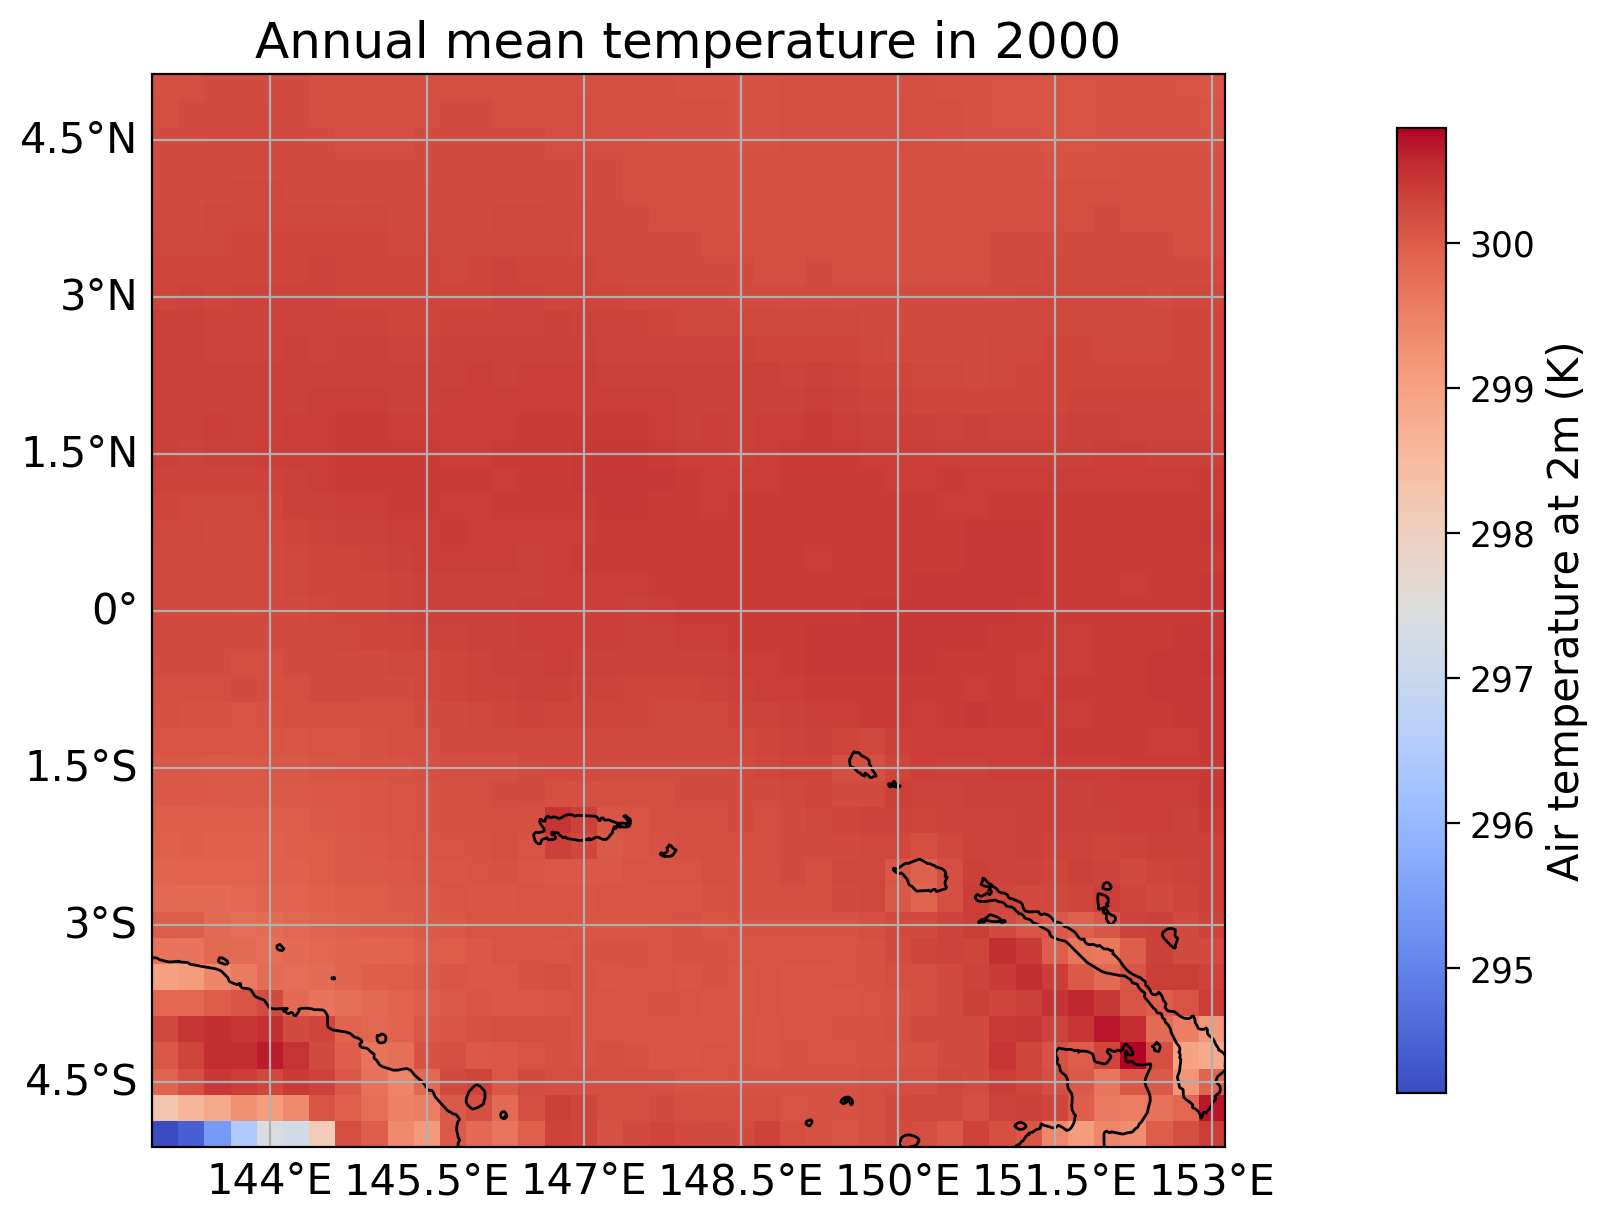

In [ ]:
# plot temperature
fig, ax = plt.subplots(1, subplot_kw={'projection':ccrs.PlateCarree()}, layout='constrained')

extent = [year_to_use.longitude.min(), year_to_use.longitude.max(), year_to_use.latitude.min(),
          year_to_use.latitude.max()]
#im = ax.imshow(year_to_use, extent=extent, transform=ccrs.PlateCarree(),cmap="coolwarm")
im = year_to_use.plot(ax=ax,
                      transform=ccrs.PlateCarree(),
                      cmap="coolwarm",
                      add_colorbar=False)

# add coastlines, labeled gridlines and continent boundaries
ax.coastlines()
ax.gridlines(draw_labels={"bottom": "x", "left": "y"})
ax.add_feature(cfeature.BORDERS, linestyle='-.')

# create colorbar and set cbar label
cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.9, pad=0.1)
cbar.set_label('Air temperature at 2m (K)')

# set title
plt.title("Annual mean temperature in 2000")
plt.show()

Additionally, you can calculate the air temperature trend. We choose a longer time period and therefore another subsample from 1991 to 2020, that we load in the next cell:

In [ ]:
link_id = "3xbq8"
fname_91_20 = "data_sample_91_2020.nc"
url_data_sample = f"https://osf.io/download/{link_id}/"
ds_long = xr.open_dataset(pooch_load(url_data_sample, fname_91_20))
ds_long

SHA256 hash of downloaded file: e4e9a81ba00d8b6582c51a43f95a8f8a66314409ebfd5b6d12e9a8ea85322b40
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


<xarray.Dataset> Size: 19MB
Dimensions:    (longitude: 21, latitude: 21, time: 10958)
Coordinates:
  * longitude  (longitude) float32 84B -80.0 -79.75 -79.5 ... -75.5 -75.25 -75.0
  * latitude   (latitude) float32 84B 0.0 -0.25 -0.5 -0.75 ... -4.5 -4.75 -5.0
  * time       (time) datetime64[ns] 88kB 1991-01-01 1991-01-02 ... 2020-12-31
Data variables:
    t2m        (time, latitude, longitude) float32 19MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-02-20 03:51:34 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


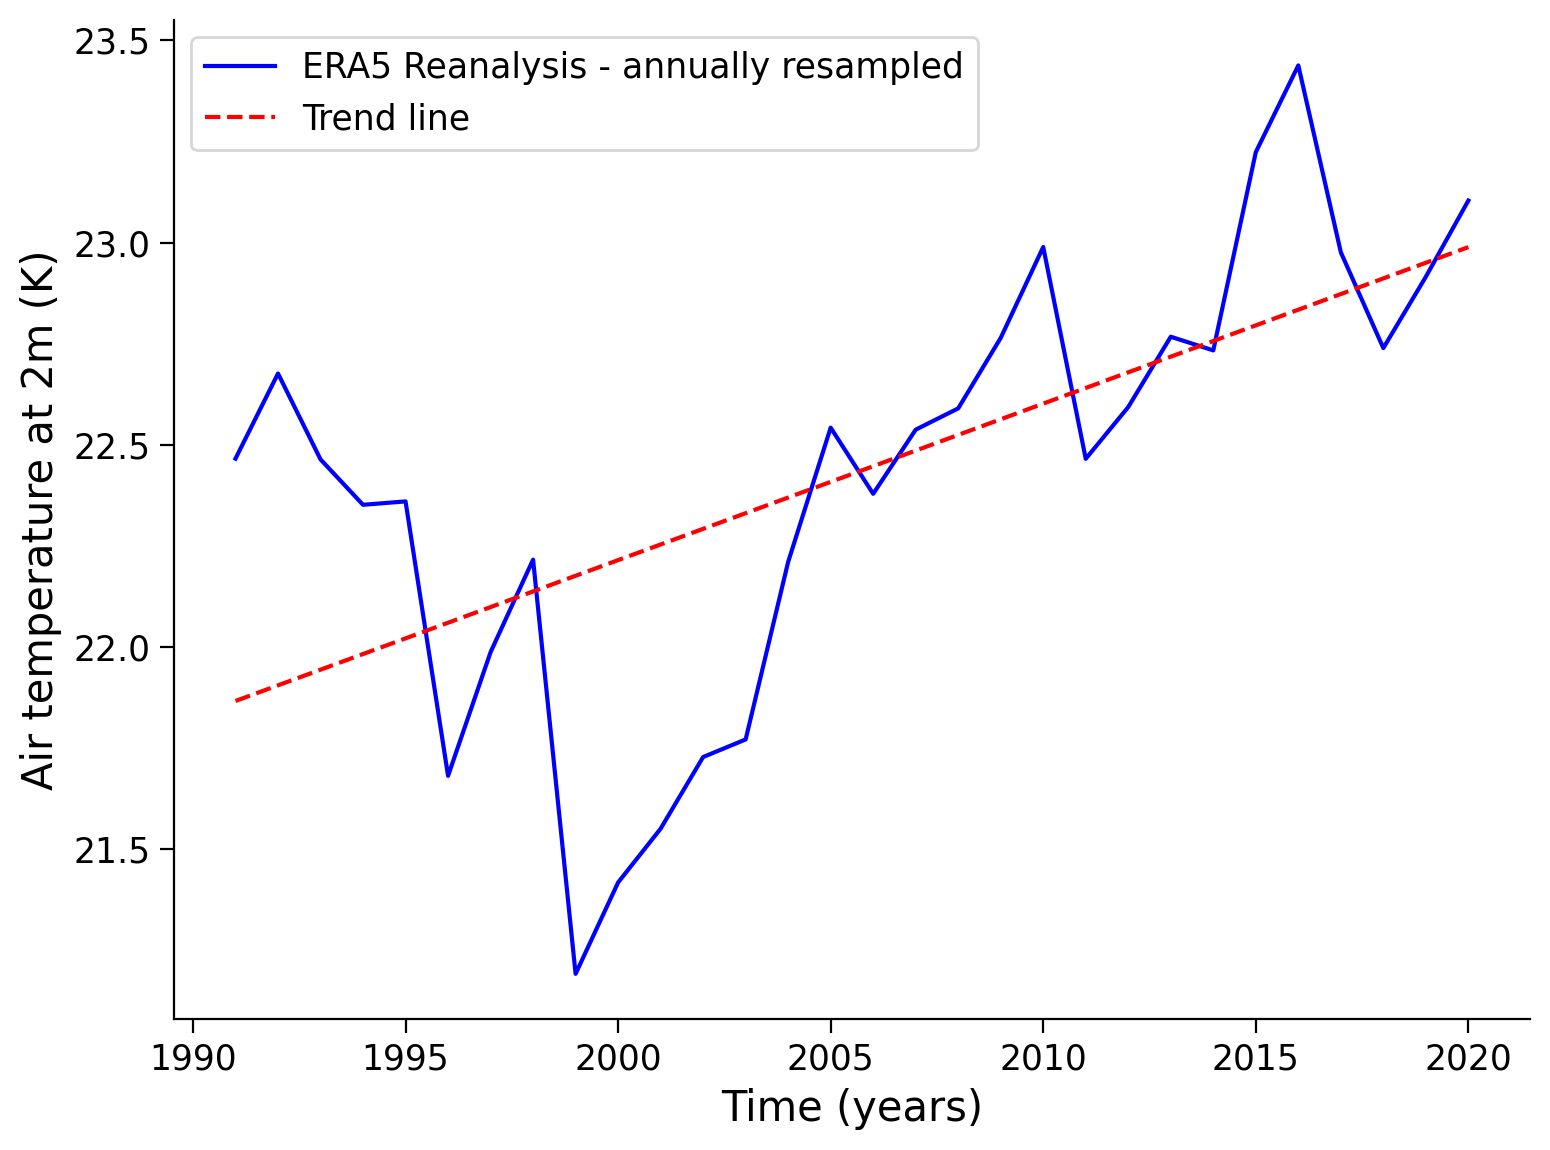

In [ ]:
# find the last year of the dataset
last_year = ds_long['time.year'].max().item()

# filter the last 30 years
ds_30y = ds_long.sel(time=slice(str(last_year-30+1),str(last_year)))

# calculate the mean temperature for each year
mean_time_dim = ds_30y['t2m'].resample(time="Y").mean(dim="time")

# apply cosine of latitude as weights to the dataset variables
weights = np.cos(np.deg2rad(mean_time_dim.latitude))
weighted_mean_time_dim = mean_time_dim.weighted(weights)

# calculate the global mean in degrees celsius
weighted_global_mean_temp = weighted_mean_time_dim.mean(dim=["longitude","latitude"])
weighted_global_mean_temp_c = weighted_global_mean_temp - 273.15

# calculate the trend line
years = weighted_global_mean_temp_c['time'].dt.year.values
annual_temperature = weighted_global_mean_temp_c.values
trend_coefficients = np.polyfit(years, annual_temperature, 1)
trend_line = np.poly1d(trend_coefficients)

# draw data
plt.plot(years, annual_temperature, color="blue", label="ERA5 Reanalysis - annually resampled")
plt.plot(years, trend_line(years), color="red", linestyle="--", label='Trend line')

# aesthetics
plt.xlabel("Time (years)")
plt.ylabel("Air temperature at 2m (K)")
plt.legend()

## ERA5-Land hourly data from 1950 to present 
This [ERA5 Reanalysis dataset](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=overview) of hourly data has an increased spatial resolution and focuses on the land variable evolution over the last decades. It is updated regularly by ECMWF and accessible via the CDS API (cf. [`get_ERA5_reanalysis_data.ipynb`](https://github.com/neuromatch/climate-course-content/blob/main/tutorials/W1D2_StateoftheClimateOceanandAtmosphereReanalysis/get_ERA5_reanalysis_data.ipynb)). A similar dataset of lower temporal resolution, i.e. monthly averages can be found [here](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land-monthly-means?tab=overview).

Depending on your research question it is essential to choose an adequate frequency, however, due to the huge amount of data available, it might become necessary to focus on a regional subset of the ERA5 dataset.

In the following, we show how we downloaded global ERA5-Land data via the CDS API to answer **Q2** by calculating global temperature trends. Please note that the API request serves as an example and the downloading process should not be triggered if not necessary. Please think about an adequate frequency and domain of interest beforehand, to request a subset that is sufficient to answer your questions.

In [ ]:
import cdsapi

#c = cdsapi.Client()

# Uncomment the following block after adjusting it according to your research question
# and after successfully working through the `get_ERA5_reanalysis_data.ipynb` notebook.

#c.retrieve(
#    'reanalysis-era5-land',
#    {
#        'variable': '2m_temperature',
#        'year': ['1974', '1975', '1976', '1977', '1978',
#                 '1979', '1980', '1981', '1982', '1983',
#                 '1984', '1985', '1986', '1987', '1988',
#                 '1989', '1990', '1991', '1992', '1993',
#                 '1994', '1995', '1996', '1997', '1998',
#                 '1999', '2000', '2001', '2002', '2003',
#                 '2004', '2005', '2006', '2007', '2008',
#                 '2009', '2010', '2011', '2012', '2013',
#                 '2014', '2015', '2016', '2017', '2018',
#                 '2019', '2020', '2021', '2022', '2023'],
#        'month': ['01','02','03','04','05','06','07','08','09','10','11','12'],
#        'day': '15',
#        'time': '12:00',
#        'grid': ['0.4', '0.4'],
#        'format': 'grib',
#
#    },
#    'reanalysis-era5-land_1974_2023_04x04.grib')

As you can see in the request code block, we downloaded the 2m_temperature / $\text{t2m}$ variable from the *reanalysis-era5-land* at noon on every 15th of the month in the last 50 years. In other words, the requested data is not averaged over the whole month but just a sample. To reduce the resolution, we chose a grid of 0.4° in both spatial dimensions. As we want to calculate global trends over the whole time period, this choice should be adequate and save us a few computational-intensive averaging calculations. Furthermore, it helps to emphasize how the downloaded data looks like. 

The output is given as a file named `reanalysis-era5-land_1974_2023_04x04.grib` in the [`grib`](https://confluence.ecmwf.int/display/CKB/What+are+GRIB+files+and+how+can+I+read+them) format, which needs a small addition in the known file reading method [`xr.open_dataset(path, engine='cfgrib')`](https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html#xarray.open_dataset), check out [this resource](https://docs.xarray.dev/en/stable/user-guide/io.html#grib-format-via-cfgrib) for more information. Additionally, we get an `idx` file that is experimental and useful if the file is opened more often but can be ignored or deleted.

Again we uploaded these files to the OSF cloud for simple data retrieval, and we converted the file format to `.nc` (NetCDF) as an additional option. The following lines help to open both file types.

***Note that the frequency of our example file `reanalysis-era5-land_1974_2023_04x04.grib` is monthly and not daily, hence no further question of the template can be answered by using it. Please increase the frequency and spatial resolution, and reduce the domain of interest when downloading the data to allow for investigations of regional heatwaves.***

In [ ]:
# specify filename and filetype
filetype = 'grib'
#filetype = 'nc'
fname_ERA5 = f"reanalysis-era5-land_1974_2023_04x04.{filetype}"

# check whether the specified path/file exists or not (locally or in the JupyterHub)
isExist = os.path.exists(fname_ERA5)

# load data and create data set
if isExist:
    _ = print(f'The file {fname_ERA5} exists locally.\n Loading the data ...\n')
    if filetype == 'grib':
        ds_global = xr.open_dataset(fname_ERA5, engine='cfgrib')
    elif filetype == 'nc':
        ds_global = xr.open_dataset(fname_ERA5)
    else:
        raise ("Please choose an appropriate file type: 'nc' or 'grib'.")

else:
    _ = print(f'The file {fname_ERA5} does not exist locally and has to be downloaded from OSF.\nDownloading the data ...\n')

    # retrieve the grib file from the OSF cloud storage
    if filetype == 'grib':
        link_id = "6d9mf"
    elif filetype == 'nc':
        link_id = "8v63z"
    else:
        raise ("Please choose an appropriate file type: 'nc' or 'grib'.")

    url_grib = f"https://osf.io/download/{link_id}/"

    # The following line is the correct approach, however, it sometimes raises an error that could not be solved by the curriculum team
    # (cf. https://github.com/ecmwf/cfgrib/blob/master/README.rst & https://github.com/pydata/xarray/issues/6512)
    # We, therefore, recommend to download the file separately if this EOFError arises.

    fcached = pooch_load(url_grib, fname_ERA5)

    try:
        if filetype == 'grib':
            ds_global = xr.open_dataset(fcached, engine='cfgrib')
        elif filetype == 'nc':
            ds_global = xr.open_dataset(fcached)
    except EOFError:
        print(f'The cached .grib file could not be parsed with Xarray.\nPlease download the file to your local directory via {url_grib} or download its NetCDF equivalent.')

print(ds_global)

The file reanalysis-era5-land_1974_2023_04x04.grib does not exist locally and has to be downloaded from OSF.



SHA256 hash of downloaded file: 91297515da329e89e4035e8e94734046ea2003259a29f10bc13069cce3654cc7
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


<xarray.Dataset> Size: 974MB
Dimensions:     (time: 600, latitude: 451, longitude: 900)
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 5kB 1974-01-15 1974-02-15 ... 2023-12-15
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 4kB 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * longitude   (longitude) float64 7kB 0.0 0.4 0.8 1.2 ... 358.8 359.2 359.6
    valid_time  (time) datetime64[ns] 5kB ...
Data variables:
    t2m         (time, latitude, longitude) float32 974MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-07-17T14:25 GRIB to CDM+CF via cfgrib-0.9.1...


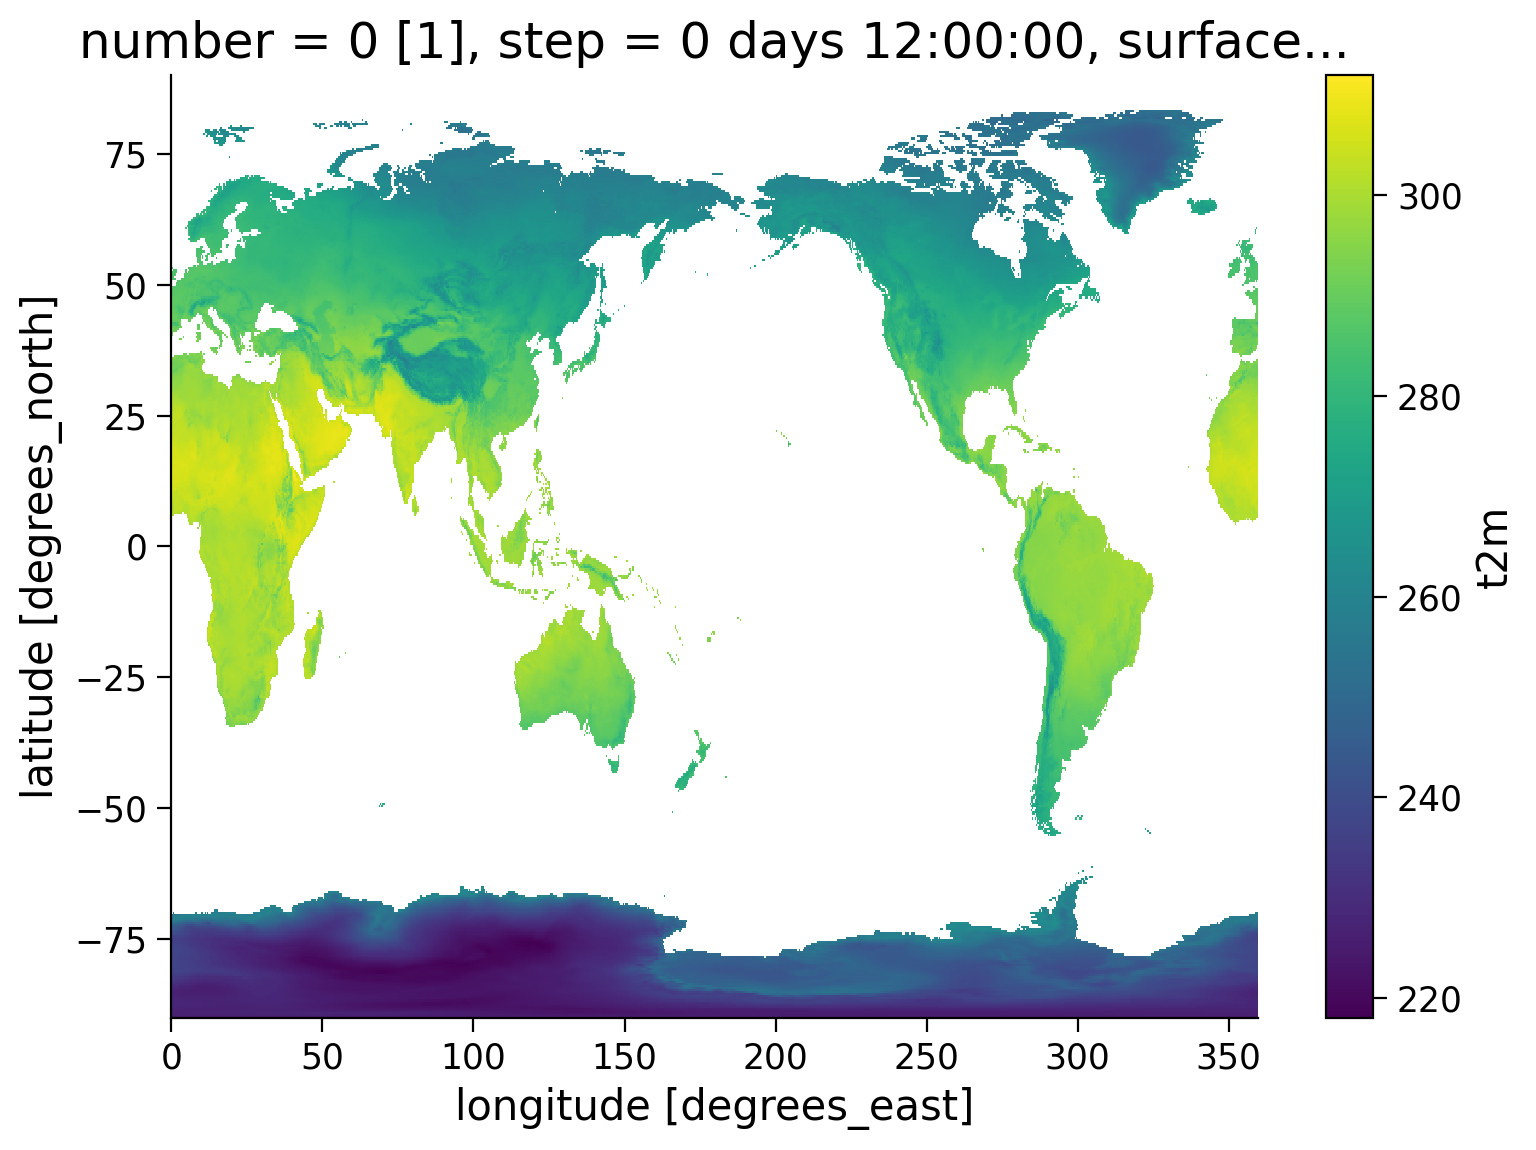

In [ ]:
# plot the mean 2m temperature of 1974 as example
t2m_1974 = ds_global.sel(time=slice('1974')).mean(dim='time')
_ = t2m_1974[list(t2m_1974.keys())[0]].plot()

## Weekly Mortality Data (Optional)

[The Organisation for Economic Co-operation and Development (OECD)](https://en.wikipedia.org/wiki/OECD) provides weekly mortality data for 38 countries. The list of countries can be found in [the OECD data explorer](https://data-explorer.oecd.org/vis?tm=weekly%20mortality&pg=0&hc[Measure]=Mortality&hc[Frequency%20of%20observation]=Weekly&snb=3&df[ds]=dsDisseminateFinalDMZ&df[id]=DSD_HEALTH_MORTALITY%40DF_MORTALITY&df[ag]=OECD.ELS.HD&df[vs]=1.0&pd=2023-W01%2C&dq=.W.M._T._T.&ly[rw]=TIME_PERIOD&ly[cl]=REF_AREA&to[TIME_PERIOD]=false) in the filters section, under *reference area*. This dataset can be used to analyze the impact of heatwaves on health through the general mortality of a country.

In [ ]:
# read the mortality data from a csv file
link_id = "rh3mp"
url = f"https://osf.io/download/{link_id}/"
#data_mortality = pd.read_csv("Weekly_mortality_OECD.csv")
data_mortality = pd.read_csv(url)
data_mortality.info()
data_mortality.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16168 entries, 0 to 16167
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   STRUCTURE_NAME            16168 non-null  object
 1   ACTION                    16168 non-null  object
 2   REF_AREA                  16168 non-null  object
 3   Reference area            16168 non-null  object
 4   FREQ                      16168 non-null  object
 5   Frequency of observation  16168 non-null  object
 6   MEASURE                   16168 non-null  object
 7   Measure                   16168 non-null  object
 8   AGE                       16168 non-null  object
 9   Age                       16168 non-null  object
 10  SEX                       16168 non-null  object
 11  Sex                       16168 non-null  object
 12  UNIT_MEASURE              16168 non-null  object
 13  Unit of measure           16168 non-null  object
 14  TIME_PERIOD           

,STRUCTURE_NAME,ACTION,REF_AREA,Reference area,FREQ,Frequency of observation,MEASURE,Measure,AGE,Age,SEX,Sex,UNIT_MEASURE,Unit of measure,TIME_PERIOD,OBS_VALUE
0,Mortality by week,I,SWE,Sweden,W,Weekly,M,Mortality,_T,Total,_T,Total,DT,Deaths,2015-W01,1927
1,Mortality by week,I,SWE,Sweden,W,Weekly,M,Mortality,_T,Total,_T,Total,DT,Deaths,2015-W02,1966
2,Mortality by week,I,SWE,Sweden,W,Weekly,M,Mortality,_T,Total,_T,Total,DT,Deaths,2015-W03,1935
3,Mortality by week,I,SWE,Sweden,W,Weekly,M,Mortality,_T,Total,_T,Total,DT,Deaths,2015-W04,1946
4,Mortality by week,I,SWE,Sweden,W,Weekly,M,Mortality,_T,Total,_T,Total,DT,Deaths,2015-W05,1975


# Hint for Q3
For this question you will calculate the percentiles, you can read more about percentiles [here](https://www.britannica.com/topic/percentile) and e.g. in W2D3 Tutorial 1. 
Furthermore, as a recommendation for this question, a definition was given to calculate heatwaves, however, there is a great diversity of definitions, you can read about it in the following article: [Perkins & Alexandar (2013)](https://doi.org/10.1175/JCLI-D-12-00383.1).

# Hint for Q4
For Question 4, to understand the method of calculating the percentage of an area under heatwaves, please read the following article: [Silva et al. (2022)](https://doi.org/10.1016/j.jenvman.2022.116193).

# Hint for Q5

The following articles will be helpful: [Heo & Bell (2019) (not open access) ](http://dx.doi.org/10.1038/s41370-018-0076-3) and [Smith et al. (2012)](https://doi.org/10.1007/s10584-012-0659-2).

# Hint for Q6

The following article will be helpful: [Reddy et al. (2022)](https://iopscience.iop.org/article/10.1088/1748-9326/ac3e9a).

# Hint for Q7
The following article will help you learn about a method to determine the influence of heatwaves on health by analyzing mortality: [Nori-Sarma et al. (2019)](https://doi.org/10.3390/ijerph16122089).

# Further reading


*   Geirinhas, J. et al. (2018) ‘Climatic and synoptic  characterization of heat waves in Brazil’, International Journal of Climatology, 38(4), pp. 1760–1776. [doi: 10.1002/joc.5294](https://doi.org/10.1002/joc.5294) (not open access)
 

*   Perkins-Kirkpatrick, S. et al. (2016) ‘Natural hazards in Australia: heatwaves’, Climatic Change. Climatic Change, 139(1), pp. 101–114. [doi: 10.1007/s10584-016-1650-0](https://doi.org/10.1007/s10584-016-1650-0) (not open access)


*   Sutanto, S. et al. (2020) ‘Heatwaves, droughts, and fires: Exploring compound and cascading dry hazards at the pan-European scale’, Environment International. Elsevier, 134(March 2019), p. 105276. [doi: 10.1016/j.envint.2019.105276](https://doi.org/10.1016/j.envint.2019.105276)


*  Lo, Y. et al. (2022) ‘Estimating heat-related mortality in near real time for national heatwave plans’, Environmental Research Letters, 17(2). [doi: 10.1088/1748-9326/ac4cf4](https://iopscience.iop.org/article/10.1088/1748-9326/ac4cf4)


*  Wilks, D. (2020) 'Statistical Methods in the Atmospheric Sciences', Elsevier. Available at: [https://doi.org/10.1016/C2017-0-03921-6](https://doi.org/10.1016/C2017-0-03921-6) (not open access)


*   World Meteorological Organization & World Health Organization. (2015) 'Heatwaves and Health
Guidance on Warning-System Development'. WMO-No. 1142. Available at: [https://library.wmo.int/idurl/4/54600](https://library.wmo.int/idurl/4/54600)

* https://ecmwf-projects.github.io/copernicus-training-c3s/reanalysis-heatwave.html